In [ ]:
#Section 1.3
from google.colab import drive
drive.mount('/content/drive')

import torch, numpy as np, matplotlib.pyplot as plt
from pathlib import Path
from typing import Dict, List

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
CKPT_DIR = Path("/content/drive/MyDrive/Model_Checkpoints/weights")

def load_ckpt(path: Path):
    ckpt = torch.load(path, map_location=DEVICE)
    sd = ckpt["model_state"]
    # strip _orig_mod. prefix if present (caused by torch.compile)
    if any(k.startswith("_orig_mod.") for k in sd.keys()):
        sd = {k.replace("_orig_mod.", "", 1): v for k, v in sd.items()}
    ckpt["model_state"] = sd
    return ckpt

s_ckpt = load_ckpt(CKPT_DIR / "sherlock_mlp.pt")
l_ckpt = load_ckpt(CKPT_DIR / "linux_mlp.pt")

s_vocab, s_inv_vocab = s_ckpt["vocab"], s_ckpt["inv_vocab"]
l_vocab, l_inv_vocab = l_ckpt["vocab"], l_ckpt["inv_vocab"]

print("Loaded:")
print("  Sherlock → vocab:", len(s_vocab), " use_adaptive:", s_ckpt["config"]["use_adaptive_softmax"])
print("  Linux    → vocab:", len(l_vocab), " use_adaptive:", l_ckpt["config"]["use_adaptive_softmax"])


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Loaded:
  Sherlock → vocab: 8151  use_adaptive: False
  Linux    → vocab: 113645  use_adaptive: True


In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class MLPTextGen(nn.Module):
    """
    Loader-friendly model that matches the training-time architecture:
      - embedding
      - 1–2 hidden MLP layers (1024)
      - proj to emb_dim
      - EITHER: tied decoder (plain softmax) OR AdaptiveLogSoftmaxWithLoss
    """
    def __init__(self, vocab_size, context_len, emb_dim, hidden_layers, hidden_dim,
                 activation="relu", dropout=0.2, use_adaptive_softmax=False, adaptive_cutoffs=None):
        super().__init__()
        self.use_adaptive = use_adaptive_softmax
        self.emb = nn.Embedding(vocab_size, emb_dim)

        act = nn.ReLU if activation.lower()=="relu" else nn.Tanh
        layers = [nn.Linear(context_len*emb_dim, hidden_dim), act(), nn.Dropout(dropout)]
        if hidden_layers == 2:
            layers += [nn.Linear(hidden_dim, hidden_dim), act(), nn.Dropout(dropout)]
        self.mlp = nn.Sequential(*layers)

        self.proj = nn.Linear(hidden_dim, emb_dim, bias=False)

        if self.use_adaptive:
            # cutoffs not needed to load; module weights come from state_dict
            if adaptive_cutoffs is None:
                cutoff1 = min(20000, vocab_size//10)
                cutoff2 = min(60000, vocab_size//2)
                adaptive_cutoffs = [c for c in [cutoff1, cutoff2] if c < vocab_size]
            self.adaptive = nn.AdaptiveLogSoftmaxWithLoss(
                in_features=emb_dim, n_classes=vocab_size, cutoffs=adaptive_cutoffs
            )
            self.decoder = None
        else:
            self.decoder = nn.Linear(emb_dim, vocab_size, bias=False)
            # weight tying
            self.decoder.weight = self.emb.weight

    def forward(self, x):
        e = self.emb(x)                       # (B, C, E)
        h = self.mlp(e.reshape(e.size(0), -1))
        z = self.proj(h)                      # (B, E)
        if self.use_adaptive:
            return z
        else:
            return self.decoder(z)            # (B, V)


In [7]:
def build_and_load(ckpt):
    cfg = ckpt["config"]
    model = MLPTextGen(
        vocab_size=cfg["vocab_size"],
        context_len=cfg["context_len"],
        emb_dim=cfg["emb_dim"],
        hidden_layers=cfg["hidden_layers"],
        hidden_dim=cfg["hidden_dim"],
        activation=cfg["activation"],
        dropout=cfg["dropout"],
        use_adaptive_softmax=cfg.get("use_adaptive_softmax", False)
    ).to(DEVICE)
    # load fixed state_dict
    missing, unexpected = model.load_state_dict(ckpt["model_state"], strict=False)
    if missing or unexpected:
        print("State dict warnings -> missing:", missing, " unexpected:", unexpected)
    model.eval()
    with torch.no_grad():
        E = model.emb.weight.detach().cpu().numpy()
    return model, E

s_model, s_E = build_and_load(s_ckpt)
l_model, l_E = build_and_load(l_ckpt)

print("Embedding shapes → Sherlock:", s_E.shape, " Linux:", l_E.shape)


Embedding shapes → Sherlock: (8151, 64)  Linux: (113645, 64)


In [8]:
import numpy as np
from sklearn.manifold import TSNE

def id2tok_from_inv(inv_vocab: Dict[str, str]) -> List[str]:
    max_id = max(int(k) for k in inv_vocab.keys())
    arr = [""]*(max_id+1)
    for k,v in inv_vocab.items():
        arr[int(k)] = v
    return arr

def tsne_2d(E, perplexity=35, seed=1337):
    tsne = TSNE(n_components=2, init="pca", learning_rate="auto",
                perplexity=min(perplexity, max(5, (len(E)-1)//3)), random_state=seed)
    return tsne.fit_transform(E)

s_id2tok = id2tok_from_inv(s_inv_vocab)
l_id2tok = id2tok_from_inv(l_inv_vocab)


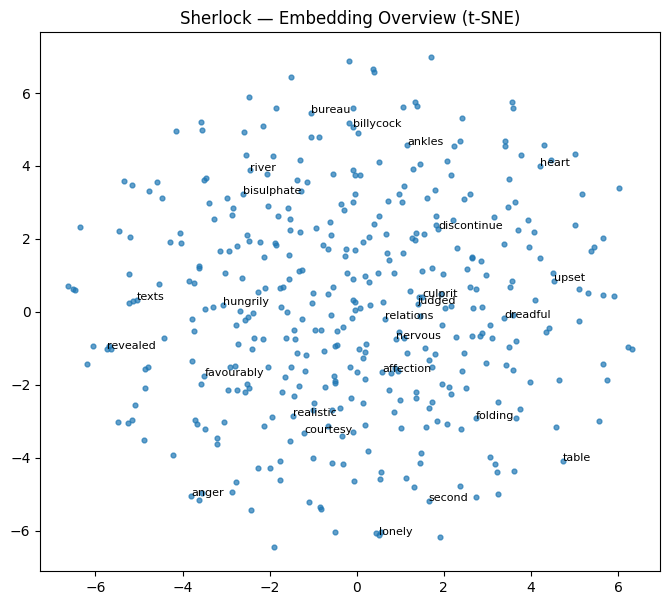

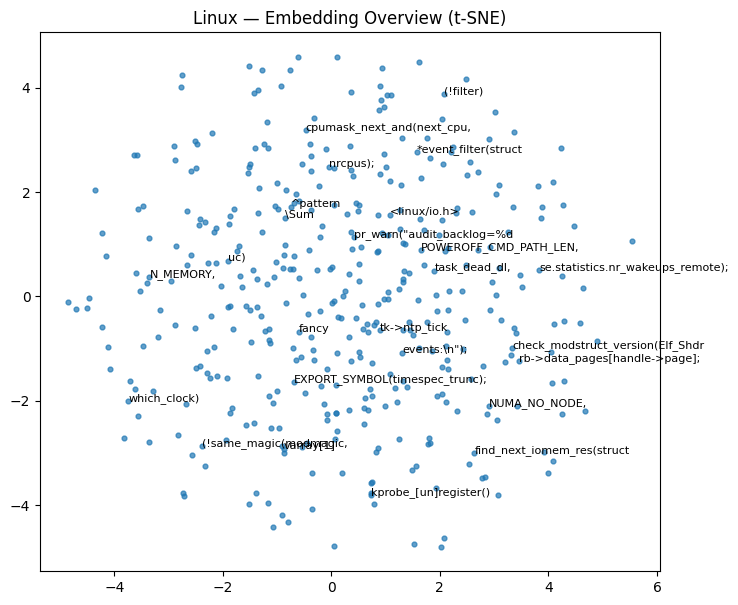

In [9]:
np.random.seed(1337)
sub_s = np.random.choice(s_E.shape[0], min(400, s_E.shape[0]), replace=False)
sub_l = np.random.choice(l_E.shape[0], min(400, l_E.shape[0]), replace=False)

s_xy = tsne_2d(s_E[sub_s])
l_xy = tsne_2d(l_E[sub_l])

plt.figure(figsize=(8,7))
plt.scatter(s_xy[:,0], s_xy[:,1], s=12, alpha=0.7)
plt.title("Sherlock — Embedding Overview (t-SNE)")
for i in np.random.choice(len(sub_s), min(25, len(sub_s)), replace=False):
    plt.annotate(s_id2tok[sub_s[i]], (s_xy[i,0], s_xy[i,1]), fontsize=8)
plt.show()

plt.figure(figsize=(8,7))
plt.scatter(l_xy[:,0], l_xy[:,1], s=12, alpha=0.7)
plt.title("Linux — Embedding Overview (t-SNE)")
for i in np.random.choice(len(sub_l), min(25, len(sub_l)), replace=False):
    plt.annotate(l_id2tok[sub_l[i]], (l_xy[i,0], l_xy[i,1]), fontsize=8)
plt.show()


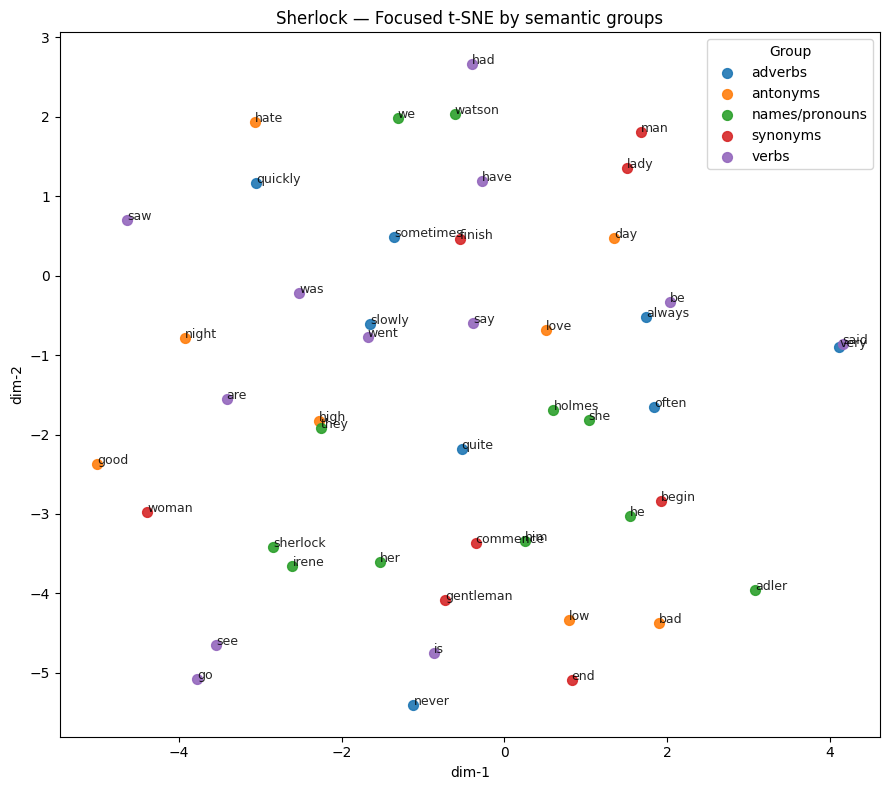

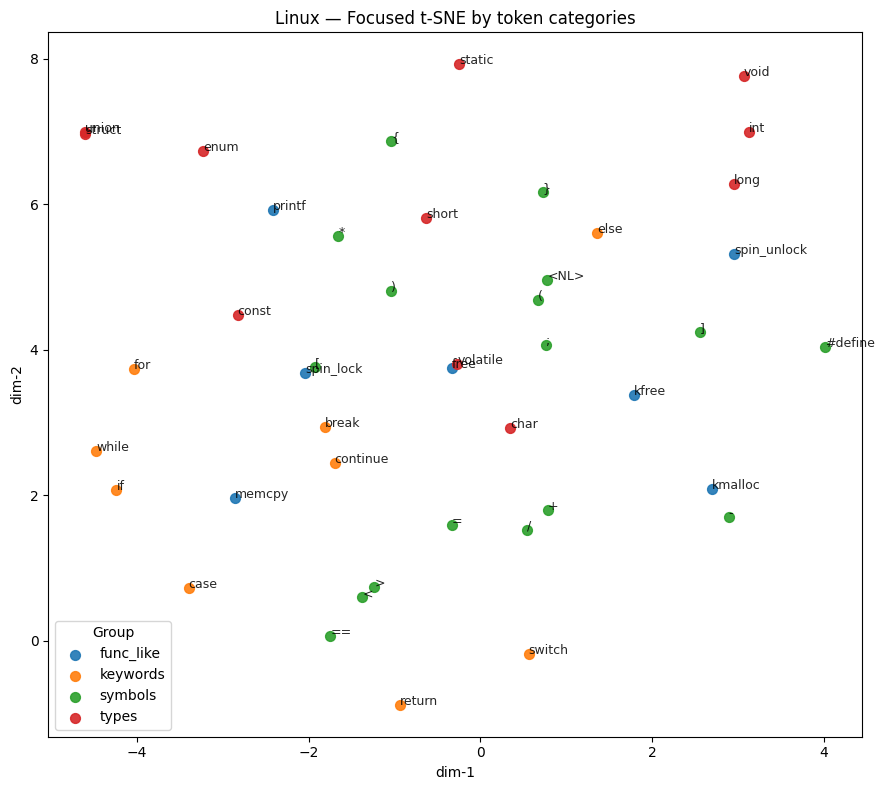


=== Sherlock neighbors ===
  sherlock → ['chaff', 'innocence', 'shabbily', 'forecastle', 'accident', 'charm', 'awake', 'carpets', '15', 'request']
    holmes → ['experiences', 'dog', 'past', 'utter', 'deathbeds', 'label', 'splashed', 'astonishment', 'arrested', 'shoving']
    watson → ['rejoin', 'had', 'harrow', 'catch', 'depends', 'enterprise', 'qualities', '150', 'accepted', 'defend']
       man → ['rabbit', 'number', 'results', 'church', 'confessed', 'extend', 'alternating', 'grief', 'jet', 'estate']
     woman → ['explain', 'eyebrows', 'were', 'merryweather', 'panoply', 'mouthed', 'powers', 'innocent', 'touch', '140']
    always → ['longer', 'staggering', '200', 'keyhole', 'be', 'nobody', 'maiden', 'august', 'grove', 'took']
         . → ['names', 'recalled', 'finished', 'show', 'difficult', 'shown', 'mansion', 'creeping', 'which', 'over']
    london → ['accurate', 'commons', 'season', 'wedged', 'sailing', 'securing', 'assizes', 'injuring', 'founded', 'mrs']

=== Linux neighbors =

In [11]:
from numpy.linalg import norm

def ensure_present(words: List[str], vocab: Dict[str,int]) -> List[str]:
    return [w for w in words if w in vocab]

def cosine_neighbors(E, vocab, id2tok, tok, topn=10):
    if tok not in vocab: return []
    q = E[vocab[tok]]
    sims = (E @ q) / (norm(E,axis=1)*norm(q) + 1e-9)
    idx = np.argsort(-sims)
    out = []
    for j in idx:
        if id2tok[j] == tok:
            continue
        out.append((id2tok[j], float(sims[j])))
        if len(out) >= topn:
            break
    return out

# Sherlock groups
names_pronouns = ensure_present(["sherlock","holmes","watson","irene","adler","he","she","him","her","we","they"], s_vocab)
verbs          = ensure_present(["is","was","are","be","have","had","say","said","see","saw","go","went"], s_vocab)
adverbs        = ensure_present(["always","never","often","sometimes","very","quite","slowly","quickly"], s_vocab)
synonyms       = ensure_present(["man","gentleman","woman","lady","begin","commence","end","finish"], s_vocab)
antonyms       = ensure_present(["good","bad","high","low","day","night","love","hate"], s_vocab)

# Linux groups
keywords   = ensure_present(["for","while","if","else","return","switch","case","break","continue"], l_vocab)
types_kw   = ensure_present(["int","long","short","void","char","struct","union","enum","const","static","volatile"], l_vocab)
symbols    = ensure_present(["{","}","(",")","[","]",";","=","==","<",">","+","-","*","/","#define","<NL>"], l_vocab)
func_like  = ensure_present(["printf","memcpy","strcpy","malloc","free","kfree","kmalloc","spin_lock","spin_unlock"], l_vocab)

def reduce_and_plot(E, id2tok, vocab, groups, title):
    """
    Produce t-SNE scatter with consistent color per group and
    alphabetically sorted legend.
    """
    # Flatten group IDs
    all_ids, group_labels = [], []
    for gname, toks in groups.items():
        ids = [vocab[t] for t in toks if t in vocab]
        all_ids.extend(ids)
        group_labels.extend([gname] * len(ids))

    if not all_ids:
        print("No tokens found for", title)
        return

    # 2D reduction
    pts = tsne_2d(E[all_ids]) if E.shape[1] > 2 else E[all_ids]

    # Assign fixed color per group (sorted)
    uniq_groups = sorted(groups.keys())
    cmap = plt.get_cmap("tab10")
    color_map = {g: cmap(i % 10) for i, g in enumerate(uniq_groups)}

    plt.figure(figsize=(9, 8))
    for gname in uniq_groups:
        idxs = [i for i, lbl in enumerate(group_labels) if lbl == gname]
        if not idxs:
            continue
        x, y = pts[idxs, 0], pts[idxs, 1]
        plt.scatter(x, y, s=50, alpha=0.9, color=color_map[gname], label=gname)
        for i in idxs:
            plt.annotate(id2tok[all_ids[i]], (pts[i, 0], pts[i, 1]), fontsize=9, alpha=0.85)

    plt.title(title)
    plt.xlabel("dim-1")
    plt.ylabel("dim-2")
    plt.legend(title="Group", loc="best", frameon=True)
    plt.tight_layout()
    plt.show()

reduce_and_plot(s_E, s_id2tok, s_vocab, {
    "names/pronouns": names_pronouns,
    "verbs": verbs,
    "adverbs": adverbs,
    "synonyms": synonyms,
    "antonyms": antonyms
}, "Sherlock — Focused t-SNE by semantic groups")

reduce_and_plot(l_E, l_id2tok, l_vocab, {
    "keywords": keywords,
    "types": types_kw,
    "symbols": symbols,
    "func_like": func_like
}, "Linux — Focused t-SNE by token categories")

# Nearest neighbors for anchors
print("\n=== Sherlock neighbors ===")
for a in ensure_present(["sherlock","holmes","watson","man","woman","always",".","london"], s_vocab):
    print(f"{a:>10s} →", [w for w,_ in cosine_neighbors(s_E, s_vocab, s_id2tok, a)])

print("\n=== Linux neighbors ===")
for a in ensure_present(["for","if","return","struct","const",";","<NL>"], l_vocab):
    print(f"{a:>10s} →", [w for w,_ in cosine_neighbors(l_E, l_vocab, l_id2tok, a)])
